In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import traceback
# from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
# from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, LeakyReLU, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.preprocessing import StandardScaler
import pandas as pd

2024-11-04 20:48:34.606643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 20:48:45.943603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-04 20:48:45.950876: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-04 20:49:35.849668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

# Data preprocessing

In [19]:
import argparse
import h5py
from sklearn.model_selection import train_test_split
import numpy as np

def create_datasets_dense(background_file, output_file, signals_files, output_signal_names, test_size=0.2, val_size=0.2, input_shape=57):    
  with h5py.File(output_file, 'w') as output_h5:

    with h5py.File(background_file, 'r') as bkg_h5:
      full_data = bkg_h5['Particles'][:,:,:-1]
      full_data = full_data.reshape(full_data.shape[0],input_shape)
      output_h5.create_dataset("X_test", data = full_data)
  
    if signals_files:
      # read SIGNAL data
      for i, signal_file in enumerate(signals_files):
        f = h5py.File(signal_file,'r')
        signal_data = f['Particles'][:,:,:-1]
        signal_data = signal_data.reshape(signal_data.shape[0],input_shape)
        output_h5.create_dataset(output_signal_names[i], data = signal_data)   
     
  return

home_path = "/fs/ddn/sdf/group/atlas/d/lizhx/"
file_path = home_path + "preprocessed_SNL_data.h5"
input_bkg_name = home_path + "Monte_Carlo/analysis/h5_output/sm_mix.h5"
# output_bkg_name = "SM_ZeroBias"
signals_files = [
  home_path + "Monte_Carlo/analysis/h5_output/hh4b.h5",
  home_path + "Monte_Carlo/analysis/h5_output/zz4l.h5",
  # home_path + "40MHZ_data/Ato4l_lepFilter_13TeV_filtered.h5",
]
signal_names = [
  "hh4b_data",
  "zz4l_data",
  # "Ato4l_data"
]

create_datasets_dense(input_bkg_name, "./MC_preprocessed_combined.h5", signals_files, signal_names)

In [20]:
# use original SM background as background
# filename = "SM_ZeroBias_dataset.h5"  # created through the original notebook
# with h5py.File(filename, 'r') as file:
#     X_train = np.array(file['X_train'])
#     X_test = np.array(file['X_test'])
#     # X_val = np.array(file['X_val'])

In [21]:
home_path = "/fs/ddn/sdf/group/atlas/d/lizhx/"
file_path = home_path + "ToyVAE/software_dev/Notebooks/monte_carlo_eval/MC_preprocessed_combined.h5"

with h5py.File(file_path, 'r') as hf:
    X_test_prescaled = hf['X_test'][:]
    zz4l_data_prescaled  = hf['zz4l_data'][:]
    hh4b_data_prescaled  = hf['hh4b_data'][:]
    # Ato4l_data_prescaled = hf['Ato4l_data'][:]
    print("Data loaded from preprocessed_SNL_data.h5")


Data loaded from preprocessed_SNL_data.h5


In [22]:
describe_df = pd.DataFrame(X_test_prescaled)
describe_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
count,44548.000000,44548.0,44548.000000,44548.000000,44548.000000,44548.000000,44548.0,44548.0,44548.0,44548.0,...,44548.000000,44548.000000,44548.000000,44548.000000,44548.000000,44548.000000,44548.000000,44548.000000,44548.000000,44548.000000
mean,48.394556,0.0,-0.006801,0.002030,-0.000099,0.000028,0.0,0.0,0.0,0.0,...,-0.002376,3.327969,-0.006768,0.001141,1.861173,-0.002053,-0.000235,1.001666,-0.003422,-0.001034
std,42.407429,0.0,1.813482,0.228069,0.013652,0.020896,0.0,0.0,0.0,0.0,...,0.827908,9.560832,0.807623,0.641384,7.114727,0.622626,0.493769,5.124645,0.464491,0.367462
min,0.226023,0.0,-3.141556,0.000000,-2.418887,-2.012013,0.0,0.0,0.0,0.0,...,-3.141568,0.000000,-4.817048,-3.141129,0.000000,-4.832668,-3.139496,0.000000,-4.778709,-3.138187
25%,26.558876,0.0,-1.590801,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.814077,0.0,-0.010084,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.110599,0.0,1.563065,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2720.826416,0.0,3.141525,41.291813,0.194088,2.617957,0.0,0.0,0.0,0.0,...,3.141098,240.979416,4.863460,3.141380,233.946365,4.855398,3.139525,152.780869,4.816811,3.134989


In [23]:
scaler = StandardScaler()
scaler.fit(X_test_prescaled)
X_test = scaler.transform(X_test_prescaled)

In [24]:
zz4l_data = scaler.transform(zz4l_data_prescaled)
hh4b_data = scaler.transform(hh4b_data_prescaled)
# Ato4l_data = scaler.transform(Ato4l_data_prescaled)

In [25]:
describe_df = pd.DataFrame(zz4l_data)
describe_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
count,30000.000000,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.259367,0.0,0.010836,125.226821,0.202550,0.364042,8.163878,-0.000366,0.000199,1.696644,...,0.004169,-0.263341,-0.000119,-0.004080,-0.209353,0.002906,0.000428,-0.165278,0.002639,0.003794
std,1.430288,0.0,1.003052,213.607101,65.751258,55.854946,20.727349,0.547967,0.793786,8.407031,...,0.587193,0.454425,0.542841,0.525558,0.413242,0.469483,0.467776,0.367697,0.415006,0.407258
min,-1.137224,0.0,-1.728501,-0.008900,-184.493434,-150.324237,0.000000,-2.504690,-3.141025,0.000000,...,-3.790770,-0.348088,-5.896696,-4.892081,-0.261597,-7.319235,-6.358627,-0.195463,-10.313688,-8.423812
25%,-0.431862,0.0,-0.858613,-0.008900,0.007238,-0.001362,0.000000,0.000000,0.000000,0.000000,...,0.002870,-0.348088,0.008380,-0.001779,-0.261597,0.003297,0.000476,-0.195463,0.007367,0.002814
50%,-0.004315,0.0,0.015338,-0.008900,0.007238,-0.001362,0.000000,0.000000,0.000000,0.000000,...,0.002870,-0.348088,0.008380,-0.001779,-0.261597,0.003297,0.000476,-0.195463,0.007367,0.002814
75%,0.594582,0.0,0.876940,217.285779,0.007238,-0.001362,0.000000,0.000000,0.000000,0.000000,...,0.002870,-0.348088,0.008380,-0.001779,-0.261597,0.003297,0.000476,-0.195463,0.007367,0.002814
max,76.693257,0.0,1.735974,4786.297036,184.467603,150.343261,520.433350,2.516723,3.141048,170.034622,...,3.795649,12.746234,5.981903,4.896138,13.756164,7.494608,6.348301,13.213680,10.058741,8.148200


In [31]:
describe_df = pd.DataFrame(X_test)
describe_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
count,4.454800e+04,44548.0,4.454800e+04,4.454800e+04,4.454800e+04,4.454800e+04,44548.0,44548.0,44548.0,44548.0,...,4.454800e+04,4.454800e+04,4.454800e+04,4.454800e+04,4.454800e+04,4.454800e+04,4.454800e+04,4.454800e+04,4.454800e+04,4.454800e+04
mean,-3.205960e-17,0.0,-1.371704e-17,-2.073506e-18,1.595005e-19,-3.190010e-18,0.0,0.0,0.0,0.0,...,3.524961e-17,7.177522e-17,2.037619e-17,7.177522e-18,-4.194863e-17,-2.504158e-17,-3.429260e-17,6.683070e-17,9.729529e-18,1.228154e-17
std,1.000011e+00,0.0,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,0.0,0.0,0.0,0.0,...,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-1.135864e+00,0.0,-1.728602e+00,-8.900429e-03,-1.771718e+02,-9.628875e+01,0.0,0.0,0.0,0.0,...,-3.791756e+00,-3.480876e-01,-5.956162e+00,-4.899260e+00,-2.615974e-01,-7.758541e+00,-6.357828e+00,-1.954628e-01,-1.028080e+01,-8.537452e+00
25%,-5.149080e-01,0.0,-8.734676e-01,-8.900429e-03,7.237865e-03,-1.361649e-03,0.0,0.0,0.0,0.0,...,2.870151e-03,-3.480876e-01,8.380387e-03,-1.779126e-03,-2.615974e-01,3.296602e-03,4.756062e-04,-1.954628e-01,7.367463e-03,2.814188e-03
50%,-1.551745e-01,0.0,-1.810562e-03,-8.900429e-03,7.237865e-03,-1.361649e-03,0.0,0.0,0.0,0.0,...,2.870151e-03,-3.480876e-01,8.380387e-03,-1.779126e-03,-2.615974e-01,3.296602e-03,4.756062e-04,-1.954628e-01,7.367463e-03,2.814188e-03
75%,2.998575e-01,0.0,8.656735e-01,-8.900429e-03,7.237865e-03,-1.361649e-03,0.0,0.0,0.0,0.0,...,2.870151e-03,-3.480876e-01,8.380387e-03,-1.779126e-03,-2.615974e-01,3.296602e-03,4.756062e-04,-1.954628e-01,7.367463e-03,2.814188e-03
max,6.301872e+01,0.0,1.736086e+00,1.810429e+02,1.422385e+01,1.252842e+02,0.0,0.0,0.0,0.0,...,3.796929e+00,2.485705e+01,6.030391e+00,4.896094e+00,3.262076e+01,7.801641e+00,6.358838e+00,2.961784e+01,1.037756e+01,8.534375e+00


In [9]:
def analyze_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")

    for col in range(57):
        column = arr[:, col]
        
        # Calculate statistics
        mean_val = np.mean(column)
        min_val = np.min(column)
        max_val = np.max(column)
        has_nan = np.isnan(column).any()
        
        # Print results
        print(f"Column {col + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Contains NaN: {has_nan}")
        print()  # Empty line for readability
analyze_columns(zz4l_data_prescaled)

Column 1:
  Mean: 0.0571
  Min: 0.0000
  Max: 52.6840
  Contains NaN: False

Column 2:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 3:
  Mean: -0.0006
  Min: -3.1009
  Max: 2.5468
  Contains NaN: False

Column 4:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 5:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 6:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 7:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 8:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 9:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 10:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 11:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 12:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 13:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Colum

# Model Specifications

In [10]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
#     x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense1")(inputs)
#     x = BatchNormalization(name="BN1")(x)
    x = ReLU(name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense2")(x)    
#     x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z_logvar=Dense(latent_dim, name='z_log_var',
                          kernel_initializer=keras.initializers.Zeros(),
                          bias_initializer=keras.initializers.Zeros(),
                          kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_2,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x=layers.Dense(h_dim_1,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=layers.Dense(input_dim,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

def Qmake_discriminator(input_dim, h_dim_1, h_dim_2):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
    x = Dense(h_dim_1,
              activation='relu',
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros(),
              kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x = Dense(h_dim_2,
              activation='relu',
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros(),
              kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    x = Dense(1,
              activation='sigmoid',  # Output probability
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros(),
              kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    discriminator = keras.Model(inputs, x, name='discriminator')
    return discriminator


def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
#     jet_scale = 256/64
#     tau_scale = 128/64
#     muon_scale = 32/64
#     met_scale = 512/64
#     em_scale = 128/64
#   no scaling right now
    jet_scale = 1
    tau_scale = 1
    muon_scale = 1
    met_scale = 1
    em_scale = 1
    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: met_scale,
        3: em_scale, 6: em_scale, 9: em_scale, 12: em_scale,
        15: tau_scale, 18: tau_scale, 21: tau_scale, 24: tau_scale,
        27: jet_scale, 30: jet_scale, 33: jet_scale, 36: jet_scale, 39: jet_scale, 42: jet_scale,
        45: muon_scale, 48: muon_scale, 51: muon_scale, 54: muon_scale
    }

    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    for index, factor in scale_dict.items():
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        scale_tensor += index_mask * (factor - 1)

    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor

    # Hardcoded lists for eta and phi indices
    eta_indices = [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
    phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56]

    batch_size = tf.shape(scaled_reconstruction)[0]
    
    # Set only the first eta (index 1) to zero
    indices = tf.stack([tf.range(batch_size), tf.ones(batch_size, dtype=tf.int32)], axis=1)
    updates = tf.zeros(batch_size)
    scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
    # Apply constraints to eta
    for i in eta_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
    # Apply constraints to phi
    for i in phi_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3.14159265258979 * tf.tanh(scaled_reconstruction[:, i] / 3.14159265258979)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
        
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)

    # Take the sum across all dimensions
    return tf.reduce_sum(mse)

class VAE_GAN_Model(keras.Model):
    def __init__(self, encoder, decoder, discriminator, steps_per_epoch=3125, 
                cycle_length=10, min_beta=0.1, max_beta=0.85, gamma = 1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta_tracker = keras.metrics.Mean(name="beta")
        # self.grad_tracker = keras.metrics.Mean(name="grad")
        self.discriminator_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.gamma = tf.Variable(gamma, dtype=tf.float32)
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)

    def compile(self, optimizer, **kwargs):
        super(VAE_GAN_Model, self).compile(**kwargs)
        # Set the optimizer for the entire model (encoder + decoder + discriminator)
        self.optimizer = optimizer

        # Collect trainable variables from encoder, decoder, and discriminator
        trainable_variables = (
            self.encoder.trainable_weights + 
            self.decoder.trainable_weights + 
            self.discriminator.trainable_weights
        )
        # Build the optimizer with the full variable list
        self.optimizer.build(trainable_variables)



    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.discriminator_loss_tracker,
            self.beta_tracker,
            # self.grad_tracker
        ]

    def cyclical_annealing_beta(self, epoch):
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        return self.min_beta + (self.max_beta - self.min_beta) * tf.minimum(x, 1.0)

    def train_step(self, data):
        # Get the current epoch number
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        
        # Update beta
        self.beta.assign(self.cyclical_annealing_beta(epoch))

        # ---------------------------
        # Train the Discriminator
        # ---------------------------
        with tf.GradientTape() as tape_disc:
            # Generate reconstructed data
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Get discriminator predictions
            real_output = self.discriminator(data)
            fake_output = self.discriminator(reconstruction)
            
            # Labels for real and fake data
            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)
            
            # Discriminator loss
            d_loss_real = keras.losses.binary_crossentropy(real_labels, real_output)
            d_loss_fake = keras.losses.binary_crossentropy(fake_labels, fake_output)
            d_loss = d_loss_real + d_loss_fake
            d_loss = tf.reduce_mean(d_loss)
        
        grads_disc = tape_disc.gradient(d_loss, self.discriminator.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_weights))
        
        # ---------------------------
        # Train the VAE (Generator)
        # ---------------------------
        with tf.GradientTape() as tape_vae:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask * data, mask * reconstruction)
            reconstruction_loss *= (1 - self.beta)
            
            # KL divergence loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= self.beta
            
            # Generator (VAE) wants to fool the discriminator
            fake_output = self.discriminator(reconstruction)
            valid_labels = tf.ones_like(fake_output)  # Try to make discriminator think reconstructions are real
            g_loss_adv = keras.losses.binary_crossentropy(valid_labels, fake_output)
            g_loss_adv = tf.reduce_mean(g_loss_adv)
            curr_training_gamma = self.gamma * (epoch / 50) 
            g_loss_adv *= curr_training_gamma
            # g_loss_adv *= self.gamma  # Weight by gamma
            
            # Total VAE loss
            total_loss = reconstruction_loss + kl_loss + g_loss_adv
        
        grads_vae = tape_vae.gradient(total_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_vae, self.encoder.trainable_weights + self.decoder.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.discriminator_loss_tracker.update_state(d_loss)
        # self.grad_tracker.update_state(global_norm)

        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "disc_loss": self.discriminator_loss_tracker.result(),
            # "grad": self.grad_tracker.result(),
            "beta": self.beta,
        }

    def test_step(self, data):
        # Forward pass
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        # Reconstruction loss
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask * data, mask * reconstruction)
        reconstruction_loss *= (1 - self.beta)
        
        # KL divergence loss
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= self.beta
        
        # Discriminator loss (only for monitoring)
        # pass both data and reconstruction through D to get generator adversarial loss
        real_output = self.discriminator(data)
        fake_output = self.discriminator(reconstruction)
        real_labels = tf.ones_like(real_output)
        fake_labels = tf.zeros_like(fake_output)
        d_loss_real = keras.losses.binary_crossentropy(real_labels, real_output)
        d_loss_fake = keras.losses.binary_crossentropy(fake_labels, fake_output)
        d_loss = d_loss_real + d_loss_fake
        d_loss = tf.reduce_mean(d_loss)
        
        # Generator adversarial loss
        valid_labels = tf.ones_like(fake_output)
        g_loss_adv = keras.losses.binary_crossentropy(valid_labels, fake_output)
        g_loss_adv = tf.reduce_mean(g_loss_adv)
        g_loss_adv *= self.gamma
        
        # Total VAE loss
        total_loss = reconstruction_loss + kl_loss + g_loss_adv
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "disc_loss": d_loss,
            "beta": self.beta_tracker.result(),
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        } 

In [11]:
def weighted_mse(y_true, y_pred, sample_weight):
    return tf.reduce_mean(tf.multiply(sample_weight, tf.square(y_true - y_pred)))

In [12]:
NUM_EPOCHS = 100
BATCH_SIZE = 16384 # 1024
STOP_PATIENCE = 15
LR_PATIENCE = 10

In [13]:
# Hyperparameters
input_dim = 57
h_dim_1 = 32
h_dim_2 = 16
latent_dim = 3
gamma = 1.0 

# Training

In [ ]:
# T2A_enc = Qmake_encoder_set_weights(X_train.shape[1], h_dim_1, h_dim_2, latent_dim)
# T2A_dec = Qmake_decoder_set_weights(X_train.shape[1], h_dim_1, h_dim_2, latent_dim)
# T2A_discriminator = Qmake_discriminator(input_dim, h_dim_1, h_dim_2)

# steps_per_epoch = X_train.shape[0] // BATCH_SIZE
# T2A = VAE_GAN_Model(T2A_enc, T2A_dec, T2A_discriminator, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.8, gamma=1000)
# opt = keras.optimizers.Adam(learning_rate=0.001)
# T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]

# T2A_enc.summary()
# T2A_dec.summary()
# T2A_discriminator.summary()

In [ ]:
# fit model & save weights

# early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

# callbacks = [early_stopping, reduce_lr]

# tf.keras.backend.clear_session()
# history = T2A.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
# T2A.save_weights(filepath=home_path+'software_dev/trained_models/toyVAE/', save_format='tf')

In [ ]:
# best_epoch = np.argmin(history.history['val_loss'])  # Best epoch index based on validation loss

# # Access the best metrics
# best_val_loss = history.history['val_loss'][best_epoch]
# best_loss = history.history['loss'][best_epoch]
# print(f"Best epoch: {best_epoch}") 
# print(f"Best training loss: {best_loss}")
# print(f"Best validation loss: {best_val_loss}")

Best epoch: 17
Best training loss: 435.11126708984375
Best validation loss: 78.87820434570312


In [ ]:
# iterate 20 times
for i in range(0,3):
    T2A_enc = Qmake_encoder_set_weights(X_train.shape[1], h_dim_1, h_dim_2, latent_dim)
    T2A_dec = Qmake_decoder_set_weights(X_train.shape[1], h_dim_1, h_dim_2, latent_dim)
    T2A_discriminator = Qmake_discriminator(input_dim, h_dim_1, h_dim_2)

    steps_per_epoch = X_train.shape[0] // BATCH_SIZE
    T2A = VAE_GAN_Model(T2A_enc, T2A_dec, T2A_discriminator, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.8, gamma=1000)
    opt = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1000)
    T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]

    early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

    callbacks = [early_stopping, reduce_lr]

    tf.keras.backend.clear_session()
    history = T2A.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
    T2A.save_weights(filepath=home_path+f'ToyVAE/software_dev/trained_models/best_GAN/iter_{i+18}/', save_format='tf')

In [ ]:

# Assuming 'history' is the object returned by your model.fit() call

# Extract the loss values
total_loss = history.history['loss']
reco_loss = history.history['reco_loss']
kl_loss = history.history['kl_loss']
val_total_loss = history.history['val_loss']
val_reco_loss = history.history['val_reco_loss']
val_kl_loss = history.history['val_kl_loss']

# Create a new figure
plt.figure(figsize=(12, 8))

# Plot training losses
plt.plot(total_loss, label='Total Loss', color='blue')
plt.plot(reco_loss, label='Reconstruction Loss', color='green')
plt.plot(kl_loss, label='KL Loss', color='red')

# Plot validation losses
plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

# Customize the plot
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Eval

In [26]:
def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    return kl_loss

def AD_score_CKL(z_mean, z_log_var):
    CKL = np.mean(z_mean**2)
    return CKL

def AD_score_MSE(s, p):
    mask = s != 0
    s1 = s * mask
    p1 = p * mask
    re_loss = np.mean((s1 - p1) ** 2)
    return re_loss

class Model_Evaluator:
    def __init__(
        self,
        model_path,
        background,
        br_weights,
        signal,
        signal_weights,
        input_dim,
        title="placeholder",
        save=False,
        labels=None,
    ):

        self.input_dim = input_dim
        vae_enc = Qmake_encoder_set_weights(input_dim, 32,16,3)
        vae_dec = Qmake_decoder_set_weights(input_dim, 32,16,3)
        vae_disc = Qmake_discriminator(input_dim, h_dim_1, h_dim_2)
        self.model = VAE_GAN_Model(vae_enc, vae_dec, vae_disc)
        self.model.load_weights(model_path).expect_partial()
        self.encoder = self.model.get_layer("encoder")
        self.signal = signal
        self.background = background
        self.br_loss = []
        self.signal_loss = []
        self.background_outputs = []
        self.signal_outputs = []
        self.title = title
        self.saveplots = save
        self.labels = labels
        self.latent_info = []
        self.br_weights = br_weights
        self.signal_weights = signal_weights

    def calculate_loss(self, l_type):
        self.signal_loss = []
        self.br_loss = []
        br = self.background

        if l_type == "CKL":
            br_latent = np.array(self.encoder.predict(br))
            self.latent_info += [br_latent[0]]
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_CKL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))
                self.latent_info += [sg_latent[0]]
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_CKL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        if l_type == "KL":
            br_latent = np.array(self.encoder.predict(br))
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_KL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))

                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_KL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]      

        if l_type == "MSE":
            br_predict = np.array(self.model.predict(br)["reconstruction"])
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_MSE(br[i], br_predict[i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_predict = np.array(self.model.predict(batch)["reconstruction"])
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_MSE(batch[i], sg_predict[i])
                    l += [loss]

                sg_loss = l
                self.signal_loss += [sg_loss]

        return [self.br_loss, self.signal_loss]  

    def GetPerformance(self, show_plot=True):
        target_fpr = 1e-5
        tpr_at_target = []

        print(f"Number of signal losses: {len(self.signal_loss)}")
        print(f"Number of labels: {len(self.labels)}")
        print(f"Number of signal weights: {len(self.signal_weights)}")
        print(f"Length of br_loss: {len(self.br_loss)}")

        plt.figure(figsize=(10, 6))
        plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal")

        for j, batch in enumerate(self.signal_loss):
            print(f"Processing batch {j}")
            print(f"Batch length: {len(batch)}")
            print(f"Signal weight length: {len(self.signal_weights[j])}")

            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = np.concatenate([np.zeros(len(self.br_loss)), np.ones(len(batch))])
            ROC_data = np.concatenate((self.br_loss, batch))

            print(f"ROC_data shape: {ROC_data.shape}")
            print(f"truth shape: {truth.shape}")
            print(f"weights shape: {weights.shape}")

            try:
                fpr, tpr, _ = sk.roc_curve(truth, ROC_data, sample_weight=weights)
                auc = sk.roc_auc_score(truth, ROC_data)

                plt.plot(fpr, tpr, label=f"{self.labels[j]}: {auc:.3f}")

                idx = np.argmin(np.abs(fpr - target_fpr))
                with np.printoptions(threshold=np.inf):
                    print(fpr)
                print("idx , tpr: ")
                print(idx)
                print(tpr[idx])
                tpr_at_target.append(tpr[idx])

                print(f"Successfully processed batch {j}")
            except Exception as e:
                print(f"Error processing batch {j}: {str(e)}")

        if show_plot:
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.xscale('log')
            plt.yscale('log')
            plt.title(f"{self.title} ROC")
            plt.vlines(target_fpr, 0, 1, colors="r", linestyles="dashed")
            plt.legend(loc="lower right")
            if self.saveplots:
                plt.savefig(
                    home_path+f"software_dev/plots/small/{self.title}_ROC.png",
                    format="png",
                    bbox_inches="tight",
                )
            plt.show()

        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        results = list(zip(self.labels, tpr_at_target))
        for label, tpr in results:
            print(f"{label}: {tpr*100:.6f}%")

        print(f"Number of results: {len(results)}")
        return results
    

      

In [27]:

def plot_histogram(eval: Model_Evaluator, bins, bg_only=False, range=None, log_scale=False):
    plt.hist(
        eval.br_loss,
        weights=eval.br_weights,
        bins=bins,
        histtype="step",
        range=range,
        label="backround num_events:{}".format(len(eval.br_loss)),
    )
    if not bg_only:
        for i, batch in enumerate(eval.signal_loss):
            plt.hist(
                batch,
                weights=eval.signal_weights[i],
                bins=bins,
                histtype="step",
                range=range,
                label=str(eval.labels[i]) + " num_events:{}".format(len(batch)),
            )
    plt.xlabel("loss")
    plt.ylabel("Frequency")
    plt.yscale("log")
    plt.title("{}_Hist".format(eval.title))
    plt.legend()

    plt.xscale('log')
    plt.yscale('log')

    print("Mean Loss")
    print(f"Background: mean:{np.average(eval.br_loss, weights=eval.br_weights):.6f} std:{np.std(eval.br_loss):.6f}")
    for signal_scores, signal_weights, label in zip(eval.signal_loss, eval.signal_weights, eval.labels):
        mean_score = np.average(signal_scores, weights=signal_weights)
        print(f"{label}: mean: {mean_score:.6f}  std:{np.std(signal_scores):.6f}")

    # plt.show()

def get_threshold_from_ROC(eval: Model_Evaluator, target_fprs = [1e-5]):
    tpr_at_target = []
    thresholds_at_target = []

    for target_fpr in target_fprs:
        for j, batch in enumerate(eval.signal_loss):
            sig_w = eval.signal_weights[j]
            br_w = eval.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(eval.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((eval.br_loss, batch))
            if np.isnan(ROC_data).any() or np.isinf(ROC_data).any():
                print("NaN in ROC_data:", np.isnan(ROC_data).any())
                print("Inf in ROC_data:", np.isinf(ROC_data).any())
                return 

            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            break  # took this loop from ROC but really only need to do once
                
        idx = np.argmin(np.abs(fpr - target_fpr))
        tpr_at_target.append(tpr[idx])
        thresholds_at_target.append(thresholds[idx])

    # print(f"\nTPR at FPR = {target_fpr} for each channel:")
    # for label, tpr, threshold in zip(eval.labels, tpr_at_target, thresholds_at_target):
    #     print(f"{label}: {tpr*100:.6f}%, Threshold = {threshold:.6f}")
    return tpr_at_target, thresholds_at_target


def plot_ROC(eval: Model_Evaluator, labels_to_plot=None):
    target_fpr = 1e-5
    tpr_at_target = []
    thresholds_at_target = []

    plt.plot(
        np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal"
    )
    for j, batch in enumerate(eval.signal_loss):
        if labels_to_plot is None or eval.labels[j] in labels_to_plot :
            sig_w = eval.signal_weights[j]
            br_w = eval.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(eval.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((eval.br_loss, batch))
            if np.isnan(ROC_data).any() or np.isinf(ROC_data).any():
                print("NaN in ROC_data:", np.isnan(ROC_data).any())
                print("Inf in ROC_data:", np.isinf(ROC_data).any())
                return 

            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr, label=eval.labels[j] + ": " + str(round(auc, 3)))
            
            idx = np.argmin(np.abs(fpr - target_fpr))
            tpr_at_target.append(tpr[idx])
            thresholds_at_target.append(thresholds[idx])

    plt.xlabel("fpr")
    plt.xlim(1e-7, 1)
    plt.ylim(1e-7, 1)
    plt.semilogx()
    plt.ylabel("tpr")
    plt.semilogy()
    plt.title("{}_ROC".format(eval.title))
    plt.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")
    plt.legend(loc="lower right")
    # plt.show()
    
    print(f"\nTPR at FPR = {target_fpr} for each channel:")
    for label, tpr, threshold in zip(eval.labels, tpr_at_target, thresholds_at_target):
        print(f"{label}: {tpr*100:.6f}%, Threshold = {threshold:.6f}")

def plot_anomaly_score_distribution(eval, bins=1000, range=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    # Determine the range for the bins
    all_scores = np.concatenate([eval.br_loss] + eval.signal_loss)
    min_score, max_score = 0.01, np.max(all_scores)
    # bin_edges = np.linspace(min_score, max_score, bins + 1)
    # bin_edges = np.logspace(np.log10(min_score), np.log10(max_score), bins + 1)
    min_range, max_range = range
    bin_edges = np.logspace(np.log10(min_range), np.log10(max_range), bins + 1)


    # Plot background distribution
    br_weights = eval.br_weights / np.sum(eval.br_weights)  # Normalize weights
    ax.hist(eval.br_loss, 
            bins=bin_edges, 
            weights=br_weights, 
            histtype='step', 
            label='Background',
            color='black', 
            density=True,
            range=range)

    # Plot signal distributions
    colors = plt.cm.rainbow(np.linspace(0, 1, len(eval.signal_loss)))
    for i, (signal_scores, signal_weights, label) in enumerate(zip(eval.signal_loss, eval.signal_weights, eval.labels)):
        # signal_weights = signal_weights / np.sum(signal_weights)  # Normalize weights
        ax.hist(signal_scores, 
                bins=bin_edges, 
                weights=signal_weights,
                histtype='step', 
                label=label, 
                color=colors[i],
                density=True, 
                range=range)

    ax.set_xlabel('Anomaly Score')
    ax.set_ylabel('Density')
    ax.set_title(f'{eval.title} Anomaly Score Distribution')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', alpha=0.7)

    ax.set_ylim(bottom=1e-4, top=10)
    ax.set_xlim(range)
    ax.set_xscale('log')
    ax.set_yscale('log')

    # plt.show()

    # Calculate and print the mean anomaly score for each distribution
    print("\nMean Anomaly Scores:")
    print(f"Background: {np.average(eval.br_loss, weights=eval.br_weights):.6f}")
    for signal_scores, signal_weights, label in zip(eval.signal_loss, eval.signal_weights, eval.labels):
        mean_score = np.average(signal_scores, weights=signal_weights)
        print(f"{label}: {mean_score:.6f}")


In [28]:
gamma_values = np.array([0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])  # List of gamma values to try
iters = 5
loss_arr = np.zeros((6, iters))
reco_loss_arr = np.zeros((6, iters))
models_array = np.empty((6, iters), dtype=object)
history_array = np.empty((6, iters), dtype=object)


Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/ToyVAE/software_dev/trained_models/best_GAN/iter_0/
Model_Evaluator instance created successfully
Calculating losses...
938/938 [==============================] - 1s 1ms/step
Losses calculated
Getting performance...
Number of signal losses: 2
Number of labels: 2
Number of signal weights: 2
Length of br_loss: 44548
Processing batch 0
Batch length: 10000
Signal weight length: 10000
ROC_data shape: (54548,)
truth shape: (54548,)
weights shape: (54548,)
[0.00000000e+00 2.24476969e-05 8.97907875e-05 8.97907875e-05
 1.57133878e-04 1.57133878e-04 2.69372362e-04 2.69372362e-04
 2.91820059e-04 2.91820059e-04 3.59163150e-04 3.59163150e-04
 4.04058544e-04 4.04058544e-04 4.48953937e-04 4.48953937e-04
 5.16297028e-04 5.16297028e-04 5.83640119e-04 5.83640119e-04
 6.28535512e-04 6.28535512e-04 6.73430906e-04 6.73430906e-04
 6.95878603e-04 6.95878603e-04 7.85669390e-04 7.85669390e-04
 8.08117087e-04 8.08117087e-04 8.30564784e-04 8.30564784e-0

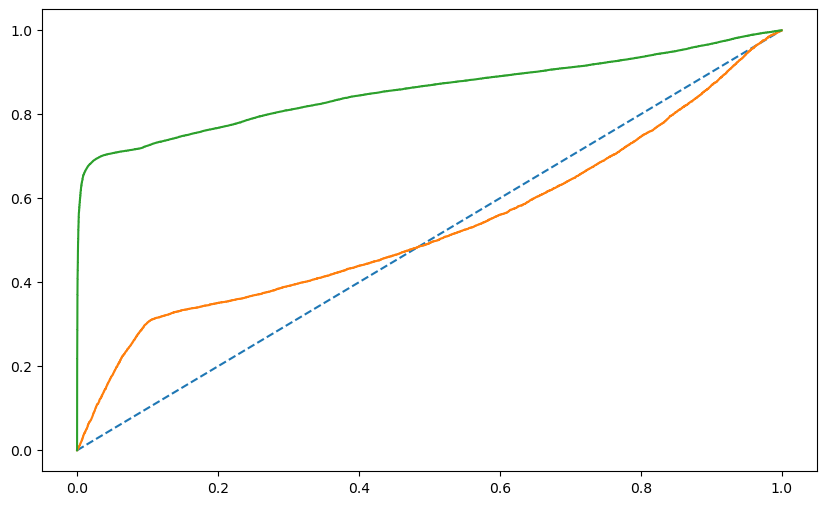

Final channel results: {'hh4b_data': [[0.0], [], [], [], [], []], 'zz4l_data': [[0.0], [], [], [], [], []]}


In [29]:
results = []
# signal_labels = ["Ato4l",
#                 "hToTauTau",
#                 "hChToTauNu",
#                 "leptoquark"
#                 ]
# signal_data = [Ato4l_data,
#                hToTauTau_data,
#                hChToTauNu_data,
#                leptoquark_data
#                ]
signal_labels = [
  "hh4b_data",
  "zz4l_data",
#   "Ato4l_data"
]
signal_data = [
               hh4b_data,
               zz4l_data,
            #    Ato4l_data,
               ]

models_to_eval = [
    (0,0),
    # (5,2)
]

evals = np.empty((6, iters), dtype=object)
channel_results = {}    # dict with key:channel value:channel[gamma][iter] 

# for i in range(1):
#     for j in range(iters) : 
for i,j in models_to_eval : 
        try:
            # model_path = home_path+f'ToyVAE/software_dev/trained_models/toyVAE/'
            model_path = home_path+f'ToyVAE/software_dev/trained_models/best_GAN/iter_{j}/'
            # model_path = home_path+f'ToyVAE/software_dev/trained_models/gamma_tuning/gamma_in_beta/iter_{j}/'
            # model_path = home_path+f'software_dev/trained_models/gamma_tuning/gamma{gamma_values[i]:.0e}/iter_{j}/'
            print(f"Evaluating model from path: {model_path}")
            evaluation = Model_Evaluator(model_path,
                                X_test,
                                np.ones(len(X_test)),
                                signal_data,
                                [np.ones(len(hh4b_data)),
                                    np.ones(len(zz4l_data)),
                                    # np.ones(len(Ato4l_data)),
                                ],
                                input_dim = X_test.shape[1],
                                # title=f'VAE Model gamma{gamma_values[i]:.0e} iter {j} large batch size',
                                title=f'VAE-GAN Model iter {j}',
                                save = False,
                                labels = signal_labels)
            
            print("Model_Evaluator instance created successfully")
            
            print("Calculating losses...")
            evaluation.calculate_loss('CKL')
            print("Losses calculated")
            
            print("Getting performance...")
            result = evaluation.GetPerformance(show_plot=False)
            print(f"GetPerformance() returned: {result}")
            
            if not result:
                print(f"Warning: GetPerformance() returned an empty result for model {j}")
            else:
                evals[i][j] = evaluation
                # evals[0][j] = evaluation
                for channel, tpr in result:
                    if channel not in channel_results:
                        channel_results[channel] = [[] for _ in range(6)]
                    channel_results[channel][i].append(tpr)
                    # channel_results[channel][0].append(tpr)
        
        except Exception as e:
            print(f"An error occurred while evaluating model {i}:")
            print(traceback.format_exc())
                
        plt.show()


print("Final channel results:", channel_results)


TPR at FPR = 1e-05 for each channel:
hh4b_data: 0.000000%, Threshold = inf
zz4l_data: 0.000000%, Threshold = inf


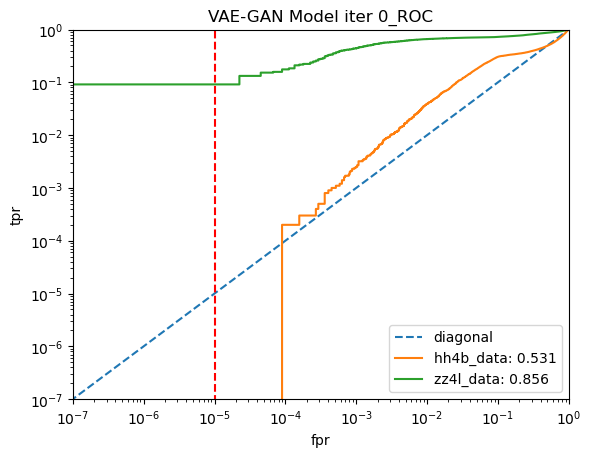


Mean Anomaly Scores:
Background: 6.637711
hh4b_data: 14.721438
zz4l_data: 1015.074215


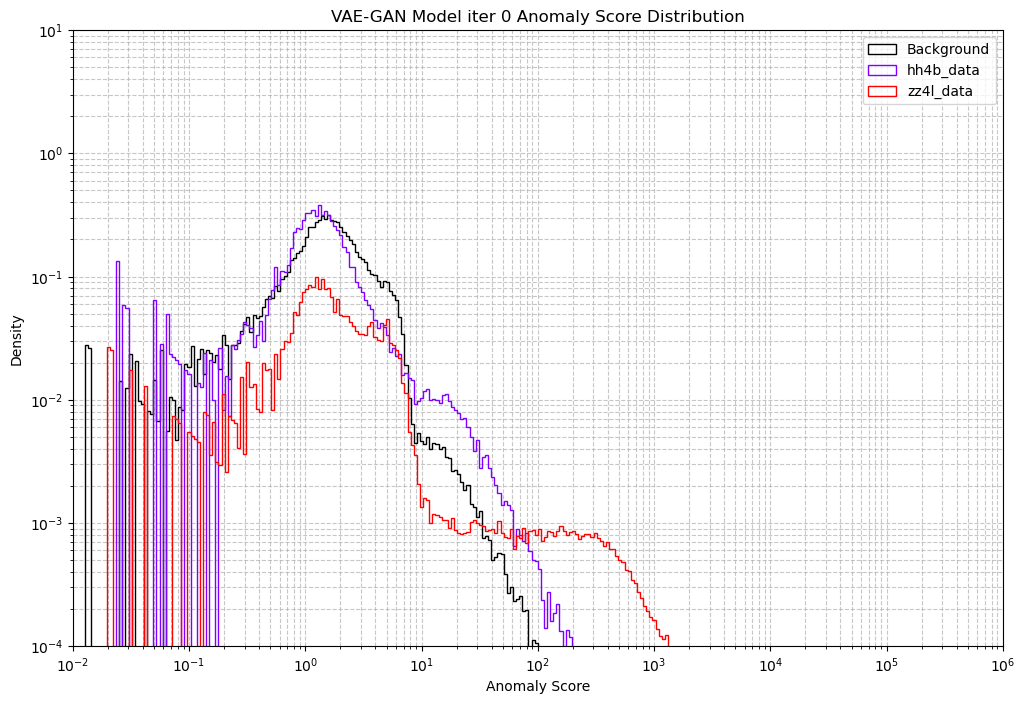

In [30]:
notable_models = [
      (0,0)
      # (5,2)
]

for (i, j) in notable_models:
# for i in range(1):
#     for j in range(iters) : 
        curr_eval = evals[i][j]
        if curr_eval is not None:
            plot_ROC(curr_eval)
            plt.show()
            plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-2, 1e6))
            plt.show()
    # plt.xlim(0,40000)
    # plt.show()



TPR at FPR = 1e-05 for each channel:
Ato4l: 6.405332%, Threshold = 237718.796875
hToTauTau: 0.109651%, Threshold = 237718.796875
hChToTauNu: 0.090362%, Threshold = 237718.796875
leptoquark: 0.095729%, Threshold = 237718.796875


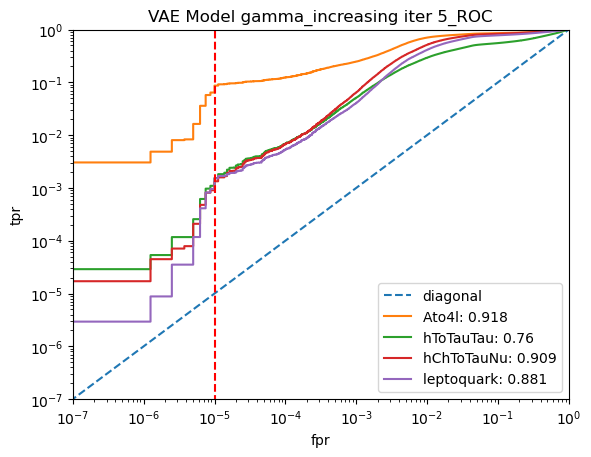


Mean Anomaly Scores:
Background: 26.899198
Ato4l: 69689.795132
hToTauTau: 1378.753123
hChToTauNu: 1309.634310
leptoquark: 1007.329391


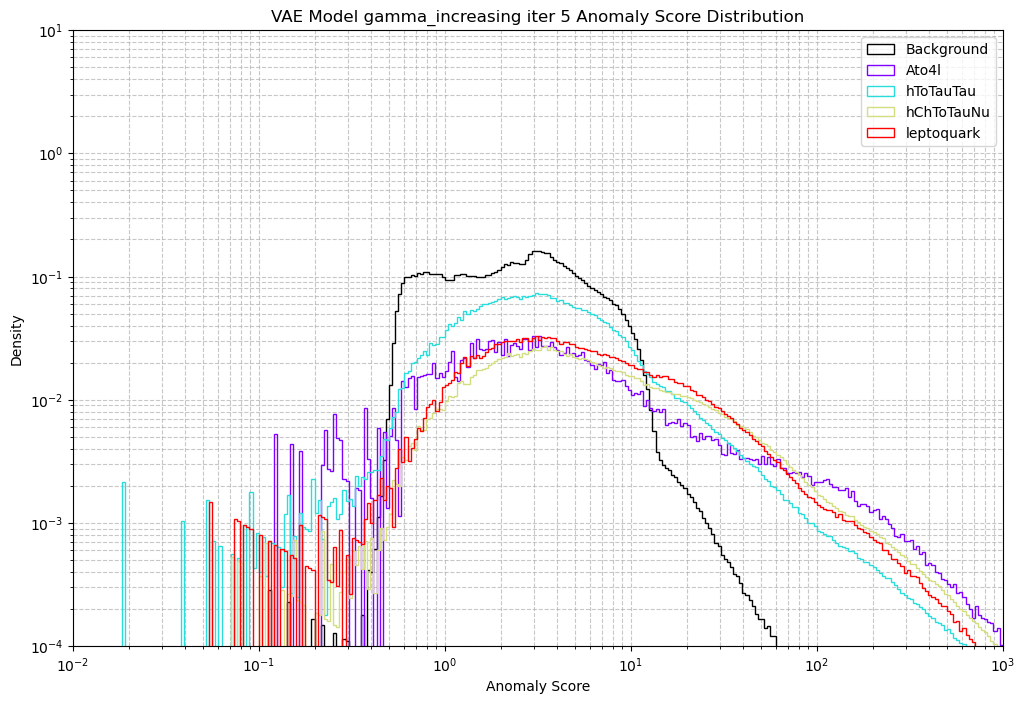


TPR at FPR = 1e-05 for each channel:
Ato4l: 6.196287%, Threshold = 706047.500000
hToTauTau: 0.120935%, Threshold = 706047.500000
hChToTauNu: 0.093914%, Threshold = 706047.500000
leptoquark: 0.088682%, Threshold = 706047.500000


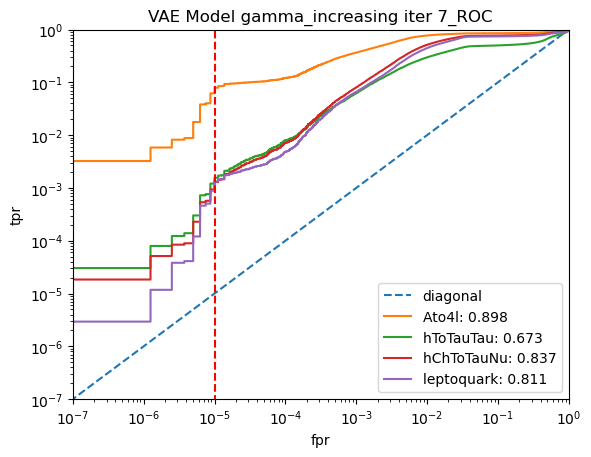


Mean Anomaly Scores:
Background: 68.722988
Ato4l: 201661.158437
hToTauTau: 4827.925939
hChToTauNu: 4385.960098
leptoquark: 3324.901860


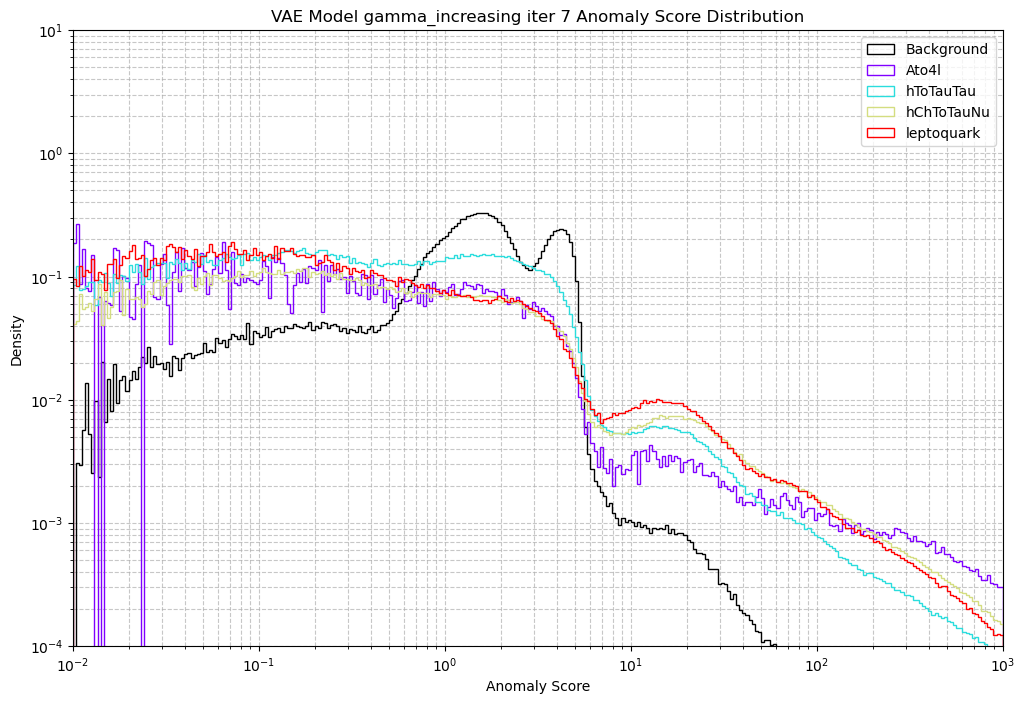

In [13]:
# gamma_increasing
notable_models = [
      (0,5),(0,7)
  # (5,2),
#   (0,4),(4,7),
  # (5,2),
#   (5,0)
  # (5,5)
]

for (i, j) in notable_models:

# for i in range(1):
#     for j in range(iters) : 
        curr_eval = evals[i][j]
        if curr_eval is not None:
            plot_ROC(curr_eval)
            plt.show()
            plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-2, 1e3))
            plt.show()
    # plt.xlim(0,40000)
    # plt.show()


In [ ]:
# LB
for i in range(1):
    for j in range(iters) : 
        curr_eval = evals[i][j]
        if curr_eval is not None:
            plot_ROC(curr_eval)
            plt.show()
            plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-2, 1e3))
            plt.show()
    # plt.xlim(0,40000)
    # plt.show()


In [ ]:
notable_models = [
  # (5,2),
  (0,4),(4,7),
  # (5,2),
  (5,0)
  # (5,5)
]

for (i, j) in notable_models:
  curr_eval = evals[i][j]
  thrs = get_threshold_from_ROC(curr_eval)
  # plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-1, 1e3))
  # plt.show()
  # plot_histogram(curr_eval, bins=100, bg_only=False)
  # plt.show()
  # plot_ROC(curr_eval)

In [ ]:
for i in range(1):
  for j in range(iters) : 
    curr_eval = evals[i][j]
    if curr_eval is not None:
        plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-1, 1e3))
        
    plt.show()


In [ ]:
labels_to_plot = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"
                ]

for i in range(1):
  for j in range(8) : 
    if evals[i][j]  is not None:
      curr_eval = evals[i][j] 
      # curr_eval.ROC(labels_to_plot=labels_to_plot)
      plot_ROC(curr_eval, labels_to_plot=labels_to_plot)
    plt.show()

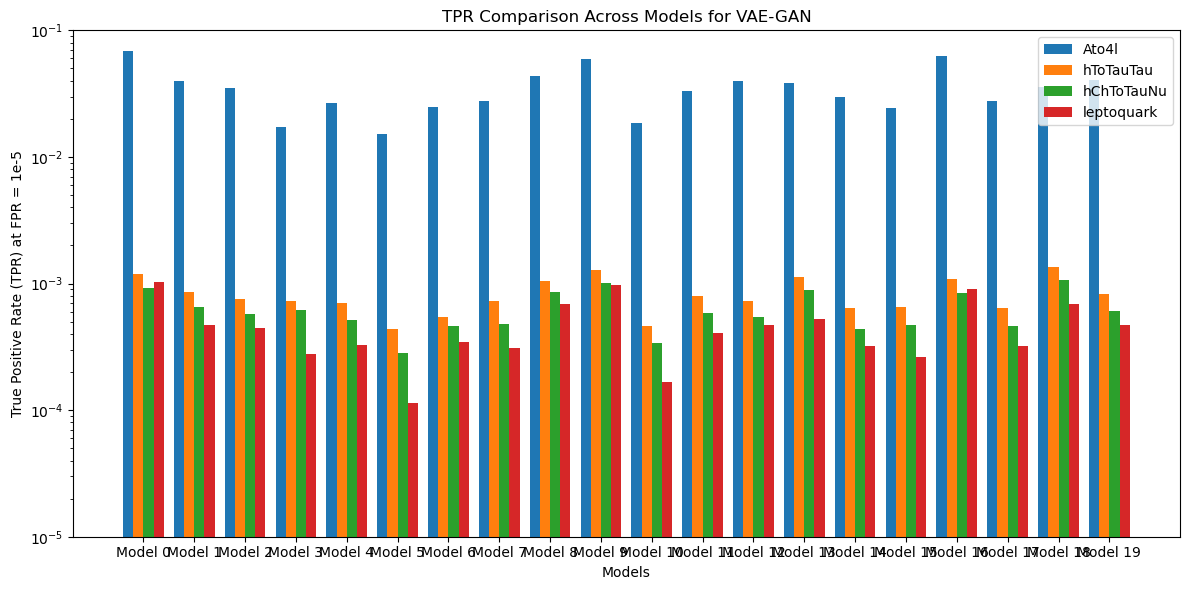


Channel Statistics:
Ato4l: Mean TPR = 3.5493%, Std Dev = 0.0143
hToTauTau: Mean TPR = 0.0828%, Std Dev = 0.0003
hChToTauNu: Mean TPR = 0.0630%, Std Dev = 0.0002
leptoquark: Mean TPR = 0.0476%, Std Dev = 0.0003


In [19]:
if channel_results:
    for g in range(1):
        plt.figure(figsize=(12, 6))
        channels = list(channel_results.keys())
        n_channels = len(channels)
        # n_models = len(channel_results[channels[0]][g])
        
        # x = np.arange(n_models)
        width = 0.8 / n_channels
        
        for i, channel in enumerate(channels):
            n_models = len(channel_results[channel][g])
            x = np.arange(n_models)

            tprs = channel_results[channel][g]
            plt.bar(x + i * width, tprs, width, label=channel)
        
        plt.xlabel('Models')
        plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
        # plt.title(f'TPR Comparison Across Models for Gamma={gamma_values[g]}')
        plt.title(f'TPR Comparison Across Models for VAE-GAN')
        plt.xticks(x + width * (n_channels - 1) / 2, [f'Model {i}' for i in range(n_models)])
        plt.yscale('log')
        plt.ylim(1e-5, 1e-1)
        plt.legend()
        plt.tight_layout()
        plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
        plt.show()
        
        # Print statistics
        print("\nChannel Statistics:")
        for channel in channels:
            tprs = channel_results[channel][g]
            mean = np.mean(tprs)
            std = np.std(tprs)
            print(f"{channel}: Mean TPR = {mean*100:.4f}%, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

In [ ]:
if channel_results:
    plt.figure(figsize=(14, 8))  # Increased figure size to accommodate the legend
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.scatter(range(n_models), tprs, label=channel, s=50)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.semilogy()
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(range(n_models), [f'{i}' for i in range(n_models)])
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Place legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

10642/10642 [==============================] - 19s 2ms/step


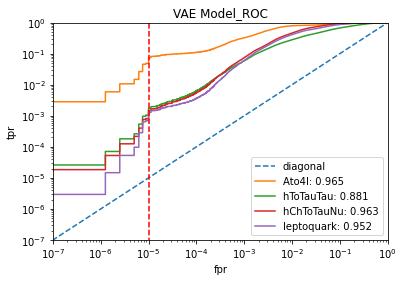


TPR at FPR = 1e-05 for each channel:
Ato4l: 4.840179%, Theshold = 177382.706232
hToTauTau: 0.104733%, Theshold = 177382.706232
hChToTauNu: 0.080761%, Theshold = 177382.706232
leptoquark: 0.069888%, Theshold = 177382.706232


In [21]:
Losses=['MSE']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/version1/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

10642/10642 [==============================] - 18s 2ms/step


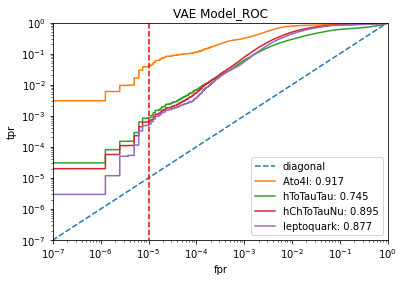


TPR at FPR = 1e-05 for each channel:
Ato4l: 3.791385%, Theshold = 34789.515625
hToTauTau: 0.083323%, Theshold = 34789.515625
hChToTauNu: 0.062741%, Theshold = 34789.515625
leptoquark: 0.049039%, Theshold = 34789.515625


In [22]:
Losses=['CKL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/version1/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

In [ ]:
Losses=['KL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/version1/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

In [18]:
print(Ato4l_data.shape)
print(hToTauTau_data.shape)
print(hChToTauNu_data.shape)
print(leptoquark_data.shape)

(55969, 57)
(691283, 57)
(760272, 57)
(340544, 57)


In [15]:
ori_vae_enc = Qmake_encoder_set_weights(X_train.shape[1], h_dim_1, h_dim_2, latent_dim)
ori_vae_dec = Qmake_decoder_set_weights(X_train.shape[1], h_dim_1, h_dim_2, latent_dim)
ori_vae_disc = Qmake_discriminator(input_dim, h_dim_1, h_dim_2)
orginal_model = VAE_GAN_Model(ori_vae_enc, ori_vae_dec, ori_vae_disc)
# orginal_model.predict(Ato4l_data)
model_path = home_path+f'ToyVAE/software_dev/trained_models/best_GAN/iter_0/'
orginal_model.load_weights(model_path)



In [18]:
def make_simplified_encoder(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim), name='input_7')
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense1")(inputs)
    x = ReLU(name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense2")(x)    
    x = ReLU(name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    new_encoder = keras.Model(inputs,z_mean,name='encoder')
    return new_encoder

In [19]:
new_encoder = make_simplified_encoder(X_train.shape[1],32,16,3)
# Transfer weights from the original encoder
for layer in new_encoder.layers:
    original_layer = ori_vae_enc.get_layer(layer.name)
    if original_layer is not None:
        print("set weight for ", layer)
        print(original_layer.get_weights())
        layer.set_weights(original_layer.get_weights())

set weight for  <keras.engine.input_layer.InputLayer object at 0x7f790d1bec70>
[]
set weight for  <keras.layers.core.dense.Dense object at 0x7f790d1beb20>
[array([[-0.01547882, -0.02397056,  0.04573698, ...,  0.02719959,
         0.03581986, -0.03418506],
       [ 0.13974726,  0.04946744,  0.09515382, ..., -0.15386175,
        -0.05671035,  0.3192179 ],
       [-0.04007775, -0.05360481,  0.08333635, ..., -0.39768013,
        -0.04267192,  0.34341452],
       ...,
       [-0.34465286,  0.26714447, -0.15911958, ..., -0.38545337,
        -0.07009339, -0.47259986],
       [-0.0325837 , -0.00907765,  0.05570788, ...,  0.08985204,
         0.05463549, -0.17282034],
       [-0.17338541,  0.27879664, -0.06965134, ..., -0.2916317 ,
         0.09005357, -0.18790884]], dtype=float32), array([ 0.12601669, -0.12868914,  0.17227797, -0.10865654,  0.18820594,
       -0.15992999,  0.76494974,  0.24277496, -0.08231556,  0.05629315,
        0.14587362,  0.06017023, -0.12854616, -0.09166819,  0.45275342,

In [20]:
trimmed_model_path = home_path+f'ToyVAE/software_dev/trimmed_models/best_GAN_iter_0/'

tf.keras.models.save_model(new_encoder, trimmed_model_path, save_format='tf')

INFO:tensorflow:Assets written to: /fs/ddn/sdf/group/atlas/d/lizhx/ToyVAE/software_dev/trimmed_models/best_GAN_iter_0/assets
